In [157]:
import os
import pickle
import warnings

import matplotlib.pyplot as plt
import pandas as pd

# import scienceplots
import seaborn as sns
from darts import TimeSeries
from darts.dataprocessing import Pipeline
from darts.dataprocessing.transformers import MissingValuesFiller, Scaler
from pandas.plotting import register_matplotlib_converters
from pylab import rcParams
from tqdm.auto import tqdm

In [2]:
warnings.filterwarnings("ignore")

In [3]:
%matplotlib inline
# %config InlineBackend.figure_format='retina'

register_matplotlib_converters()
# sns.set(style='whitegrid', palette='muted', font_scale=1.5)
sns.set_theme()


rcParams['figure.figsize'] = 12, 5
# tqdm.pandas()

In [4]:
os.getcwd()

'/home/jovyan/work'

## Carregando os dados pré processados

In [5]:
data_path = os.path.join(os.curdir, "data")
df_static = pd.read_parquet(os.path.join(data_path, "5G_df_static.parquet"))
df_driving = pd.read_parquet(os.path.join(data_path, "5G_df_driving.parquet"))

## Separando os conjuntos em: Streaming vs. Downloading.

In [6]:
list_static_strm = df_static.query("User_Activity == 'Streaming Video'")
list_driving_strm = df_driving.query("User_Activity == 'Streaming Video'")
list_static_down = df_static.query("User_Activity == 'Downloading a File'")
list_driving_down = df_driving.query("User_Activity == 'Downloading a File'")

In [7]:
list_driving_down

,Speed,NetworkMode,RSRP,RSRQ,SNR,CQI,RSSI,DL_bitrate,UL_bitrate,State,Uid,User_Activity
Timestamp,,,,,,,,,,,,
2019-12-14 10:16:30,0,5G,-99.0,-15.0,6.0,12.0,-90.0,7,1,D,Pv6HRmzr,Downloading a File
2019-12-14 10:16:31,1,5G,-99.0,-15.0,6.0,12.0,-90.0,7,1,D,Pv6HRmzr,Downloading a File
2019-12-14 10:16:32,1,5G,-102.0,-14.0,6.0,12.0,-90.0,0,0,D,Pv6HRmzr,Downloading a File
2019-12-14 10:16:33,1,5G,-102.0,-14.0,6.0,12.0,-90.0,9,12,D,Pv6HRmzr,Downloading a File
2019-12-14 10:16:34,1,5G,-102.0,-14.0,4.0,12.0,-90.0,0,0,D,Pv6HRmzr,Downloading a File
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-27 20:50:01,24,HSPA+,-71.0,NaN,NaN,NaN,NaN,4616,74,D,cfyxYgEy,Downloading a File
2020-02-27 20:50:02,24,HSPA+,-71.0,NaN,NaN,NaN,NaN,5089,88,D,cfyxYgEy,Downloading a File
2020-02-27 20:50:03,24,HSPA+,-69.0,NaN,NaN,NaN,NaN,5383,105,D,cfyxYgEy,Downloading a File


## Separar as séries temporais com base nos diferentes traços de dados identificados pelo UID

Para possibilitar utilizar o codigo do ``src``

In [8]:
import os
import sys

# Caminho absoluto ou relativo ao diretório 'src'
src_path = os.path.abspath(os.path.join(os.getcwd(), "src"))

# Adiciona o caminho ao sys.path se ainda não estiver lá
if src_path not in sys.path:
    sys.path.append(src_path)

print(f"'src' configurado como raiz de importação: {src_path}")

'src' configurado como raiz de importação: /home/jovyan/work/src


In [9]:
from utils import separate_by_uid_and_frequency

In [10]:
config = {"H": 10, "K": 50, "target_columns": ["RSRP", "RSRQ", "SNR", "CQI", "RSSI"]}
print(config)

{'H': 10, 'K': 50, 'target_columns': ['RSRP', 'RSRQ', 'SNR', 'CQI', 'RSSI']}


In [11]:
list_static_strm = separate_by_uid_and_frequency(
    list_static_strm, config["target_columns"], "S"
)
list_driving_strm = separate_by_uid_and_frequency(
    list_driving_strm, config["target_columns"], "S"
)
list_static_down = separate_by_uid_and_frequency(
    list_static_down, config["target_columns"], "S"
)
list_driving_down = separate_by_uid_and_frequency(
    list_driving_down, config["target_columns"], "S"
)

## Verificando os valores NaN de cada categoria

In [12]:
def calculate_nan_percentage(dataframes):
    """
    Calcula a porcentagem de valores NaN para cada coluna de cada DataFrame em uma lista 
    e retorna um DataFrame consolidado com os resultados.

    Args:
        dataframes (list[pd.DataFrame]): Lista de DataFrames para análise.

    Returns:
        pd.DataFrame: DataFrame consolidado com as porcentagens de NaN por coluna e por índice de DataFrame.
    """
    results = []
    
    for i, df in enumerate(dataframes):
        if isinstance(df, pd.DataFrame):  # Verifica se é um DataFrame válido
            nan_percentage = (df.isna().sum() / len(df)) * 100
            nan_percentage.name = f"DataFrame_{i}"  # Nomeia a série com o índice do DataFrame
            results.append(nan_percentage)
        else:
            print(f"Elemento {i} não é um DataFrame. Ignorando.")
    
    # Concatena os resultados em um único DataFrame
    consolidated_df = pd.concat(results, axis=1)
    consolidated_df.columns = [f"DataFrame_{i}" for i in range(len(results))]
    
    return consolidated_df


In [13]:
calculate_nan_percentage(list_static_down)

,DataFrame_0,DataFrame_1,DataFrame_2,DataFrame_3,DataFrame_4
RSRP,16.32101,16.304348,13.102542,16.523728,14.86854
RSRQ,16.32101,16.521739,13.102542,16.523728,14.86854
SNR,16.32101,16.304348,13.102542,16.523728,14.86854
CQI,16.32101,16.304348,13.102542,16.523728,14.86854
RSSI,16.32101,16.304348,13.190184,16.523728,14.86854


In [14]:
calculate_nan_percentage(list_static_strm)

,DataFrame_0,DataFrame_1,DataFrame_2,DataFrame_3,DataFrame_4,DataFrame_5,DataFrame_6,DataFrame_7,DataFrame_8,DataFrame_9,DataFrame_10,DataFrame_11,DataFrame_12,DataFrame_13,DataFrame_14,DataFrame_15,DataFrame_16,DataFrame_17
RSRP,7.582609,10.103583,7.430464,7.325684,7.637475,7.171079,7.583333,7.506053,8.300985,7.326196,7.153502,7.156720,6.824754,6.688295,6.280788,7.223169,6.552018,7.614369
RSRQ,7.582609,10.103583,7.509934,7.855252,7.637475,7.171079,7.583333,7.506053,8.300985,7.339095,7.153502,7.156720,10.699826,6.688295,6.280788,7.223169,8.143832,7.614369
SNR,7.582609,10.103583,34.622517,11.209179,7.637475,7.171079,7.583333,7.506053,8.300985,10.047723,7.153502,7.156720,10.699826,6.688295,6.280788,7.223169,8.143832,7.614369
CQI,7.582609,10.103583,34.622517,11.209179,7.637475,7.171079,7.583333,7.506053,8.300985,10.047723,7.153502,7.156720,10.699826,6.688295,6.280788,7.223169,8.143832,7.614369
RSSI,24.939130,100.000000,48.185430,23.477493,19.959267,13.216120,19.611111,12.550444,100.000000,10.408874,19.374069,7.933042,100.000000,100.000000,100.000000,8.313458,100.000000,28.492478


In [15]:
calculate_nan_percentage(list_driving_down)

,DataFrame_0,DataFrame_1,DataFrame_2,DataFrame_3,DataFrame_4,DataFrame_5,DataFrame_6,DataFrame_7,DataFrame_8,DataFrame_9,DataFrame_10,DataFrame_11,DataFrame_12,DataFrame_13,DataFrame_14,DataFrame_15
RSRP,13.19797,15.835616,16.566717,12.571429,12.090874,12.647929,12.811694,15.346038,15.980861,15.647339,12.144703,13.647059,15.474113,12.135593,15.124153,15.808014
RSRQ,13.19797,15.835616,37.181409,12.571429,12.090874,12.647929,12.811694,74.122367,15.980861,34.207043,12.144703,66.352941,15.590460,12.135593,77.088036,23.161603
SNR,100.00000,15.835616,37.181409,12.571429,12.090874,34.911243,44.969905,74.122367,15.980861,30.341541,12.144703,66.352941,15.474113,12.135593,77.088036,23.161603
CQI,100.00000,15.835616,37.181409,12.571429,12.090874,34.911243,44.969905,74.122367,15.980861,30.341541,12.144703,66.470588,15.474113,12.135593,77.088036,23.161603
RSSI,100.00000,15.835616,37.181409,17.790476,17.250674,39.423077,51.504729,74.122367,15.980861,30.341541,12.144703,66.352941,15.474113,16.881356,77.088036,23.161603


<Axes: xlabel='Timestamp'>

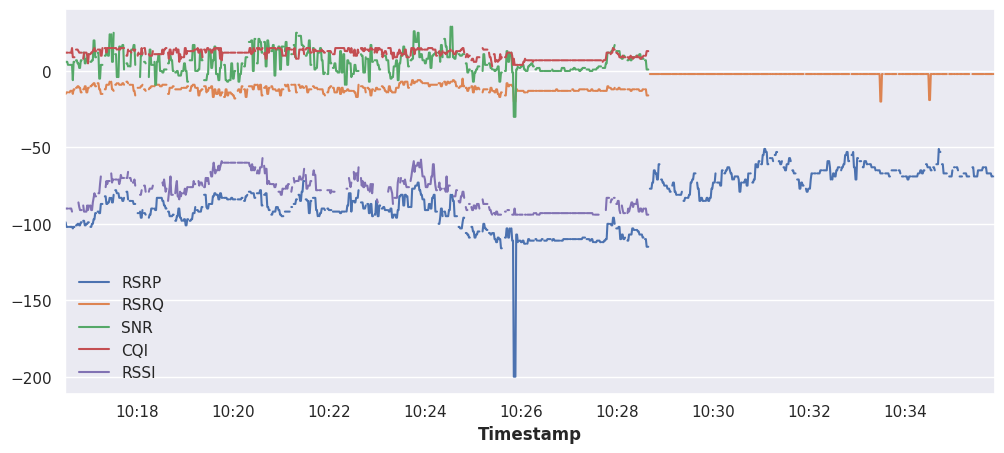

In [177]:
list_driving_down[6].plot()

In [180]:
filler = MissingValuesFiller(fill=0.0)  # Preenche valores ausentes
scaler = Scaler()  # Escalona os dados
pipe = Pipeline([filler, scaler])

<Axes: xlabel='Timestamp'>

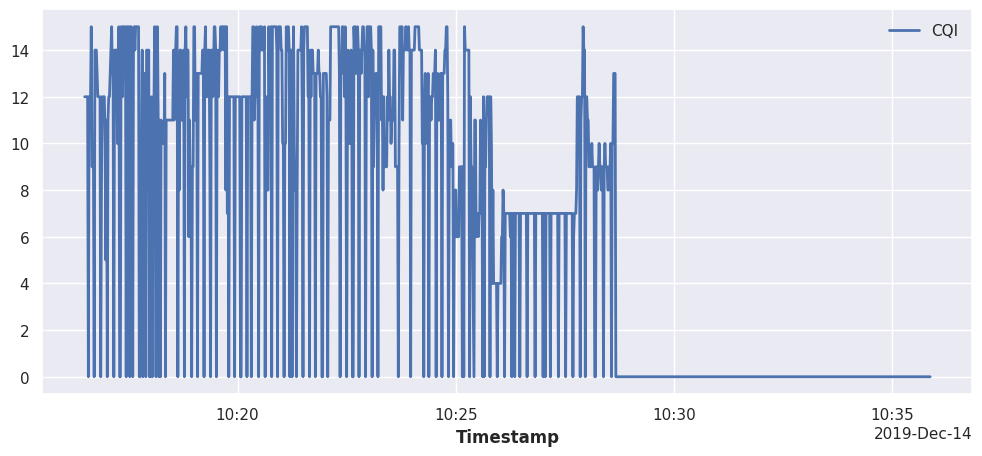

In [182]:
ts_filled = filler.transform(TimeSeries.from_dataframe(list_driving_down[6])["CQI"])
ts_filled.plot()

<Axes: xlabel='Timestamp'>

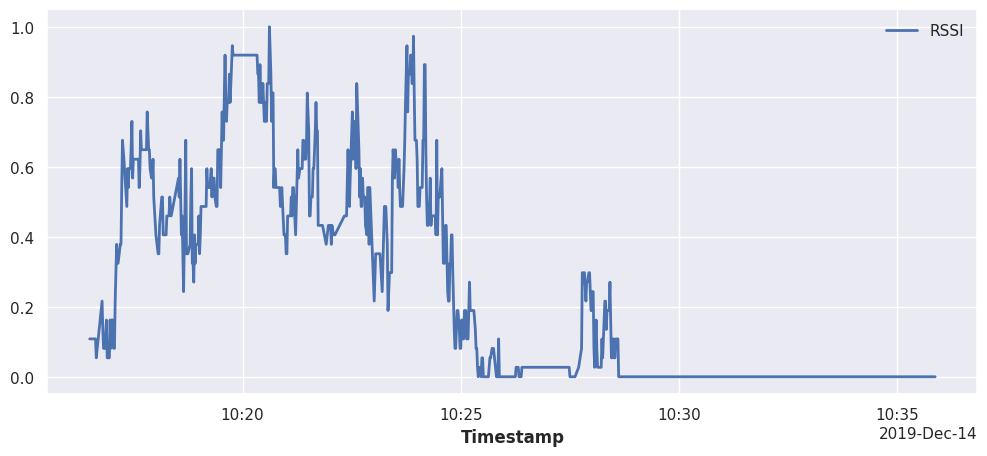

In [176]:
ts_filled = pipe.fit_transform(TimeSeries.from_dataframe(list_driving_down[6])["RSSI"])
ts_filled.plot()

<Axes: xlabel='Timestamp'>

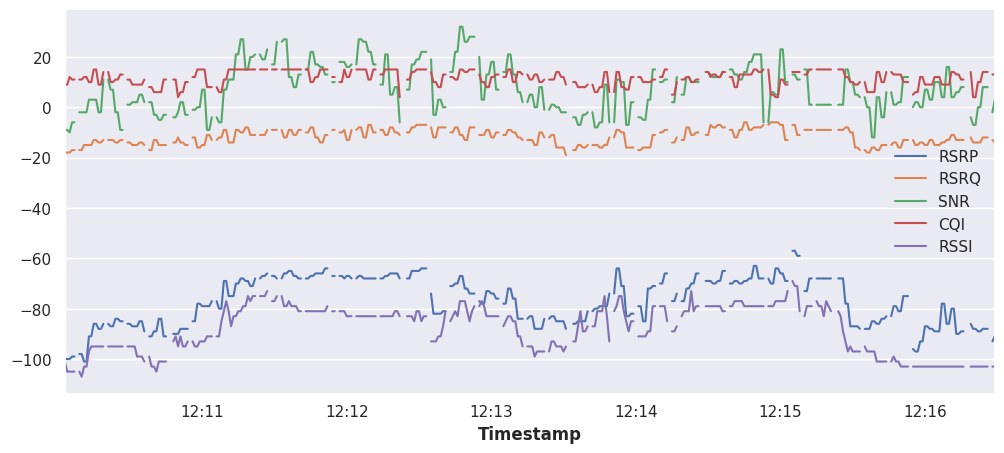

In [17]:
list_driving_down[10].plot()

<Axes: xlabel='Timestamp'>

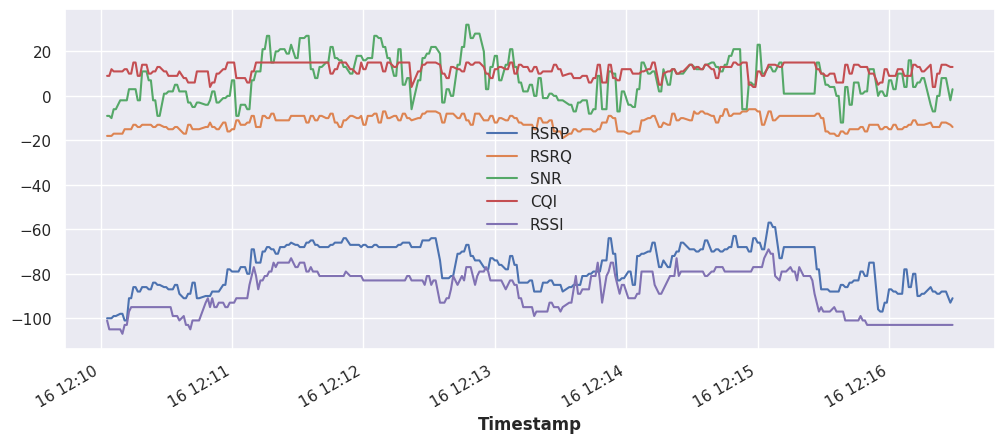

In [18]:
list_driving_down[10].dropna(how="all").fillna(method="bfill").plot()

In [19]:
list_driving_down[13].dropna(how="all").fillna(method="bfill")

,RSRP,RSRQ,SNR,CQI,RSSI
Timestamp,,,,,
2019-12-16 14:23:32,-92.0,-19.0,-11.0,8.0,-85.0
2019-12-16 14:23:33,-93.0,-19.0,-11.0,5.0,-75.0
2019-12-16 14:23:34,-95.0,-17.0,-8.0,11.0,-78.0
2019-12-16 14:23:35,-95.0,-17.0,-8.0,11.0,-78.0
2019-12-16 14:23:37,-95.0,-17.0,-8.0,10.0,-81.0
...,...,...,...,...,...
2019-12-16 15:12:37,-85.0,-10.0,12.0,11.0,-67.0
2019-12-16 15:12:38,-85.0,-10.0,12.0,11.0,-67.0
2019-12-16 15:12:39,-83.0,-7.0,11.0,11.0,-67.0


In [20]:
calculate_nan_percentage(list_driving_strm)

,DataFrame_0,DataFrame_1,DataFrame_2,DataFrame_3,DataFrame_4,DataFrame_5,DataFrame_6,DataFrame_7,DataFrame_8,DataFrame_9,...,DataFrame_34,DataFrame_35,DataFrame_36,DataFrame_37,DataFrame_38,DataFrame_39,DataFrame_40,DataFrame_41,DataFrame_42,DataFrame_43
RSRP,6.980057,6.633021,10.566763,9.978769,11.091480,10.942843,11.359026,11.562324,10.540360,10.760402,...,11.390771,11.509669,8.087291,7.902736,7.428872,11.752361,11.664226,7.025641,7.312925,10.497238
RSRQ,6.980057,6.633021,10.566763,9.978769,11.091480,10.942843,11.359026,11.562324,10.540360,10.760402,...,11.390771,11.509669,8.087291,7.902736,7.428872,11.752361,11.664226,7.025641,7.312925,10.865562
SNR,6.980057,6.633021,10.566763,66.666667,22.673734,23.155838,11.359026,11.562324,26.484323,10.760402,...,47.402388,11.509669,9.884467,13.920973,17.228662,11.752361,11.664226,7.025641,7.312925,85.267035
CQI,6.980057,6.633021,10.566763,66.666667,22.673734,23.155838,11.359026,11.562324,26.484323,10.760402,...,47.402388,11.509669,9.884467,13.920973,17.228662,11.752361,11.664226,7.025641,7.312925,85.267035
RSSI,15.384615,12.689257,23.631124,70.276008,29.034158,30.679043,14.300203,17.371686,30.353569,20.946915,...,55.211359,15.252651,21.822850,20.911854,20.969442,17.628541,16.642265,12.564103,20.663265,86.372007



## Carregando os datasets preparados para treino

In [107]:
# from darts.datasets import ElectricityDataset

# series = ElectricityDataset().load()

# series[0]

In [183]:
# Caminho do arquivo Pickle contendo as séries temporais
pickle_file_path = './data/sliding_window_datasets/driving_down_sliding_window.pkl'

# Carregar as séries temporais do arquivo Pickle
with open(pickle_file_path, 'rb') as f:
    time_series_list = pickle.load(f)


<Axes: xlabel='Timestamp'>

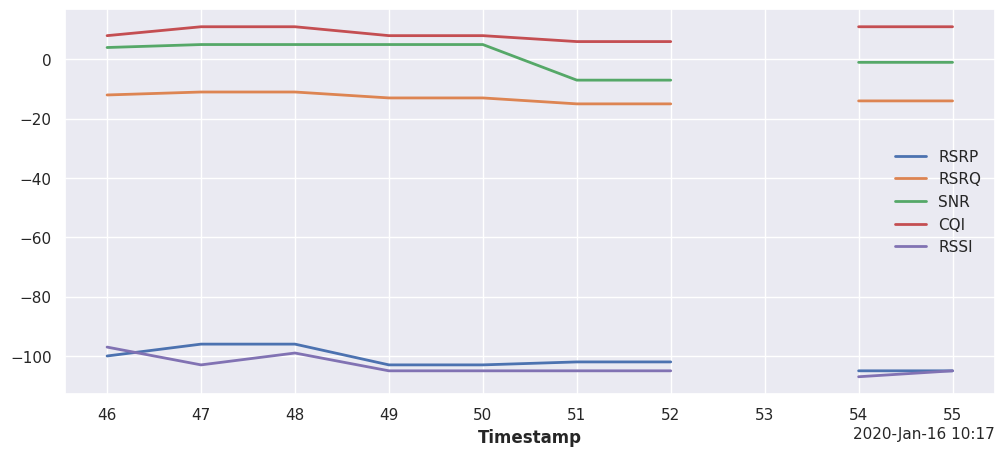

In [147]:
time_series_list[200]["test"].plot()

## Mais análises

In [21]:
static_uids = sorted(df_static.Uid.unique().tolist())
display(list(static_uids), f"Quantidade de leituras: {len(static_uids)}")

['42u9UgcX',
 '5TsXJ7Qb',
 '7NmJqtz6',
 '8xwG8Adi',
 'BFgLsizB',
 'ECU7zaAw',
 'GM9ZmFvH',
 'Jhuygmvf',
 'K23smRbN',
 'NsJRz5VB',
 'PQYS4CPo',
 'RGq3ChHg',
 'StMQQFT7',
 'T2versha',
 'Tu48fb57',
 'WNu4V7YR',
 'dGgkDzKH',
 'fJgqmnpu',
 'hk8oyFMg',
 'iNbnVB4U',
 'ksBwo2ee',
 'nD878saz',
 'nwa4P5em']

'Quantidade de leituras: 23'

User_Activity
Streaming Video       18
Name: Uid, dtype: int64

<Axes: xlabel='User_Activity'>

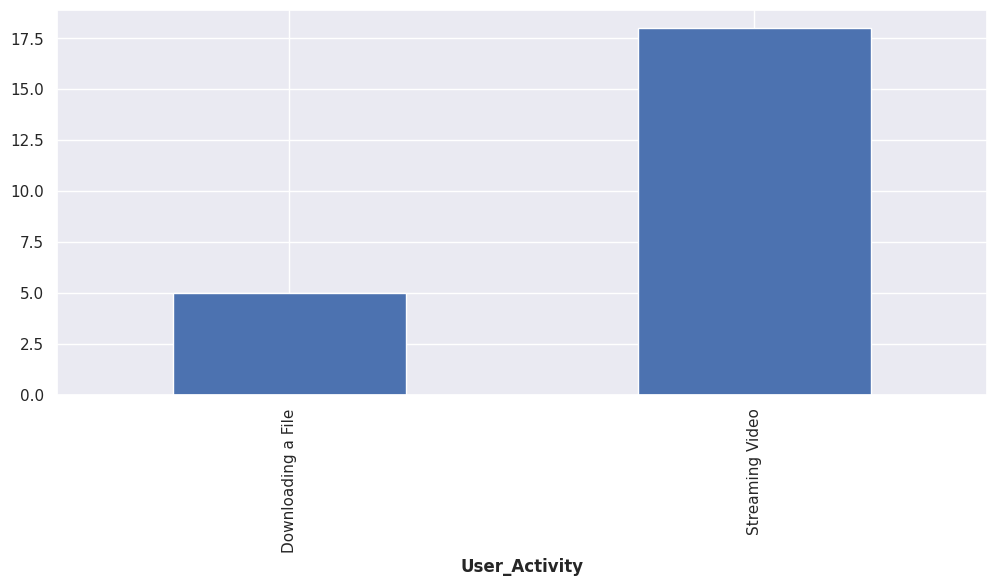

In [22]:
display(df_static.groupby("User_Activity")['Uid'].nunique())
df_static.groupby("User_Activity")['Uid'].nunique().plot(kind="bar")

In [23]:
df_static[df_static.Uid == static_uids[0]].head(10)

,Speed,NetworkMode,RSRP,RSRQ,SNR,CQI,RSSI,DL_bitrate,UL_bitrate,State,Uid,User_Activity
Timestamp,,,,,,,,,,,,
2019-11-26 13:50:48,0,5G,-106.0,-13.0,6.0,11.0,NaN,0,0,I,42u9UgcX,Streaming Video
2019-11-26 13:50:49,0,5G,-107.0,-14.0,4.0,11.0,NaN,0,0,I,42u9UgcX,Streaming Video
2019-11-26 13:50:50,0,5G,-107.0,-14.0,4.0,11.0,NaN,0,0,I,42u9UgcX,Streaming Video
2019-11-26 13:50:51,0,5G,-106.0,-13.0,1.0,11.0,NaN,2,4,D,42u9UgcX,Streaming Video
2019-11-26 13:50:52,0,5G,-106.0,-13.0,1.0,13.0,-88.0,433,245,D,42u9UgcX,Streaming Video
2019-11-26 13:50:53,0,5G,-103.0,-14.0,4.0,12.0,-86.0,11366,497,D,42u9UgcX,Streaming Video
2019-11-26 13:50:54,0,5G,-103.0,-14.0,4.0,12.0,-86.0,18419,672,D,42u9UgcX,Streaming Video
2019-11-26 13:50:55,1,5G,-103.0,-14.0,4.0,12.0,-86.0,18419,672,D,42u9UgcX,Streaming Video
2019-11-26 13:50:57,1,5G,-103.0,-17.0,2.0,12.0,-86.0,5464,206,D,42u9UgcX,Streaming Video


In [24]:
test_static_df = (
    df_static[df_static.Uid == static_uids[0]][["RSRP", "RSRQ", "SNR", "CQI", "RSSI"]]
    .asfreq(freq="S")
    # .bfill()
)
test_static_df.head(10)

,RSRP,RSRQ,SNR,CQI,RSSI
Timestamp,,,,,
2019-11-26 13:50:48,-106.0,-13.0,6.0,11.0,NaN
2019-11-26 13:50:49,-107.0,-14.0,4.0,11.0,NaN
2019-11-26 13:50:50,-107.0,-14.0,4.0,11.0,NaN
2019-11-26 13:50:51,-106.0,-13.0,1.0,11.0,NaN
2019-11-26 13:50:52,-106.0,-13.0,1.0,13.0,-88.0
2019-11-26 13:50:53,-103.0,-14.0,4.0,12.0,-86.0
2019-11-26 13:50:54,-103.0,-14.0,4.0,12.0,-86.0
2019-11-26 13:50:55,-103.0,-14.0,4.0,12.0,-86.0
2019-11-26 13:50:56,NaN,NaN,NaN,NaN,NaN


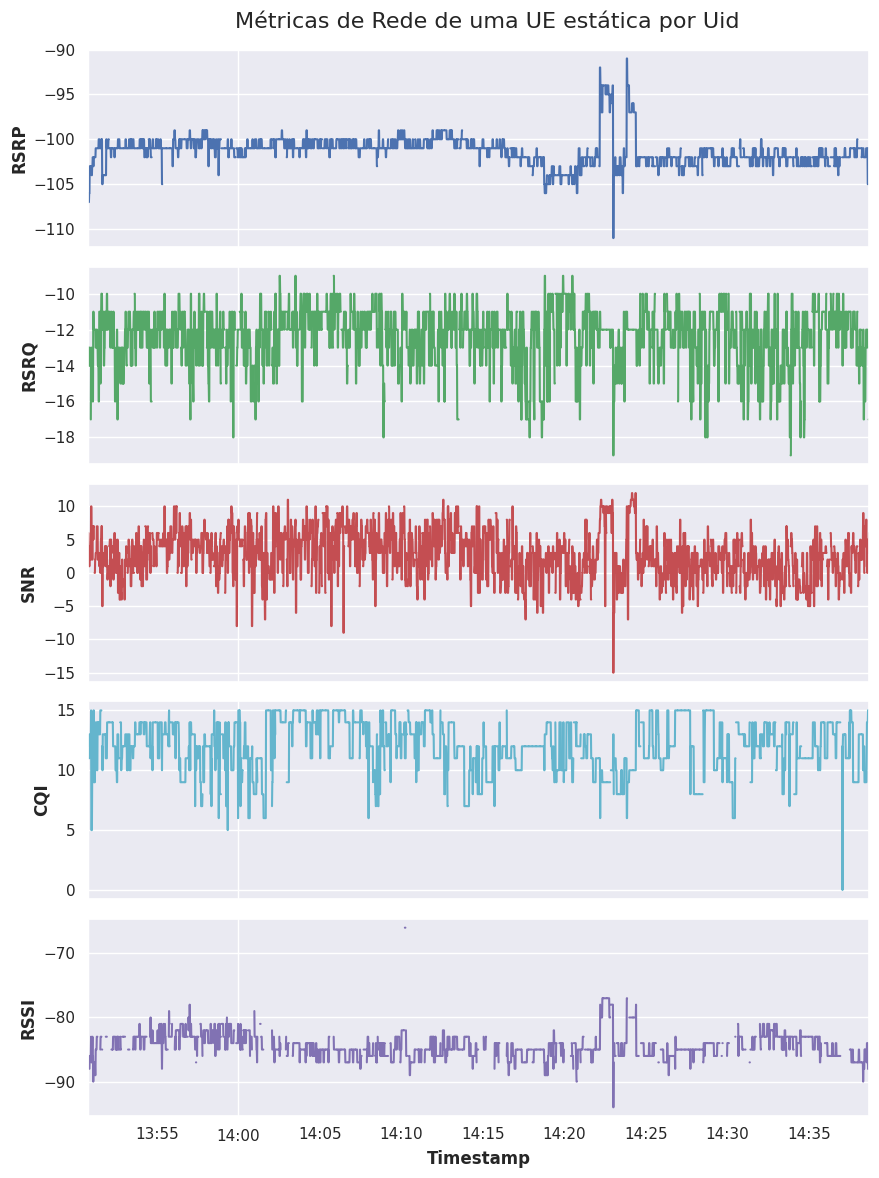

In [25]:
# Criar a figura e os eixos
fig, ax = plt.subplots(5, 1, figsize=(10, 12), sharex=True)

# Plotar as variáveis nos subplots
test_static_df.plot(kind="line", y="RSRP", color="b", ax=ax[0], legend=False)
test_static_df.plot(kind="line", y="RSRQ", color="g", ax=ax[1], legend=False)
test_static_df.plot(kind="line", y="SNR", color="r", ax=ax[2], legend=False)
test_static_df.plot(kind="line", y="CQI", color="c", ax=ax[3], legend=False)
test_static_df.plot(kind="line", y="RSSI", color="m", ax=ax[4], legend=False)

# Definir os títulos de cada eixo y
ax[0].set_ylabel("RSRP")
ax[1].set_ylabel("RSRQ")
ax[2].set_ylabel("SNR")
ax[3].set_ylabel("CQI")
ax[4].set_ylabel("RSSI")

fig.suptitle("Métricas de Rede de uma UE estática por Uid", fontsize=16)

# # Configurar a legenda em uma posição consistente
# lines = [ax[0].lines[0], ax[1].lines[0], ax[2].lines[0], ax[3].lines[0], ax[4].lines[0]]
# labels = ["RSRP", "RSRQ", "SNR", "CQI", "RSSI"]
# fig.legend(lines, labels, loc="upper right", bbox_to_anchor=(1.1, 1), title="Métricas")

# Ajustar o layout para evitar sobreposição
plt.tight_layout(rect=[0, 0, 0.9, 1])

In [26]:
ts_static = TimeSeries.from_dataframe(
    test_static_df,
    value_cols=["RSRP", "RSRQ", "SNR", "CQI", "RSSI"],
    # fill_missing_dates=True,  # Adiciona NaN para os segundos ausentes
    # freq="s",
)

In [27]:
ts_static.time_index.values

array(['2019-11-26T13:50:48.000000000', '2019-11-26T13:50:49.000000000',
       '2019-11-26T13:50:50.000000000', ...,
       '2019-11-26T14:38:40.000000000', '2019-11-26T14:38:41.000000000',
       '2019-11-26T14:38:42.000000000'], dtype='datetime64[ns]')

In [28]:
ts_static["RSRP"].all_values().flatten()

array([-106., -107., -107., ..., -101., -101., -101.])

## Driving

In [14]:
df_driving = pd.read_parquet(
    os.path.join(os.curdir, "data", "5G_df_driving.parquet")
)

In [15]:
driving_uids = sorted(df_driving.Uid.unique().tolist())
display(list(driving_uids), f"Quantidade de leituras: {len(driving_uids)}")

['297FZypZ',
 '4F2EyAD3',
 '4dRydYjp',
 '6WrsU6ix',
 '9DWopAGC',
 'AGgmh8yf',
 'AsFpmia9',
 'BMGPBjya',
 'C55SDPhc',
 'D7S47wsb',
 'DGUzdHuE',
 'DwGchQdb',
 'EFh7zDgY',
 'EjHAbVMV',
 'HThSzqKR',
 'HaCeE7bY',
 'J24QkZ2u',
 'J4V6Y25d',
 'JsVEJPwy',
 'K6TUUt3r',
 'LFvR86yz',
 'LUnJJANP',
 'Lm4nnZ3y',
 'N5MLYKPm',
 'NKpgdgV2',
 'NQBoGSiU',
 'QLGJh8iL',
 'R6WuRYsG',
 'RngjUM9j',
 'S8T9Psem',
 'TdPps7ts',
 'USfaqZw5',
 'Urb4trhB',
 'UsyKjy6F',
 'V8v7LRaC',
 'Vt8bosWC',
 'Vx2d8RdC',
 'WhUU4LAT',
 'XeL3nqTb',
 'Y5FhsGKa',
 'Z62L5upe',
 'ZQKVQjuh',
 'aaKkzbhj',
 'dyU6zEzJ',
 'eGbYrDta',
 'eqWpbbNX',
 'f3sTfFKF',
 'g3QU7W4C',
 'hzLTojbW',
 'iD2CYP32',
 'iVRz9MhC',
 'iYDrhdHp',
 'iqSNwzTV',
 'jpwbCC3y',
 'kmTLbSon',
 'mFsVp3xN',
 'mRnvfwGW',
 'mqxcBQJT',
 'nLFJYs33',
 'nhatZCUd']

'Quantidade de leituras: 60'

User_Activity
Streaming Video       44
Name: Uid, dtype: int64

<Axes: xlabel='User_Activity'>

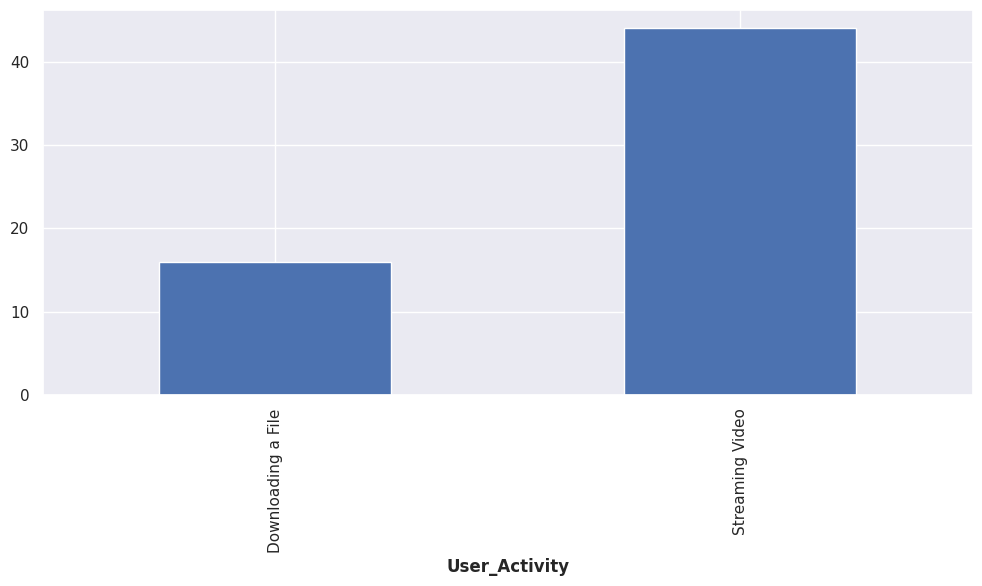

In [16]:
display(df_driving.groupby("User_Activity")['Uid'].nunique())
df_driving.groupby("User_Activity")['Uid'].nunique().plot(kind="bar")

In [17]:
df_driving.query("User_Activity == 'Downloading a File'")

,Speed,NetworkMode,RSRP,RSRQ,SNR,CQI,RSSI,DL_bitrate,UL_bitrate,State,Uid,User_Activity
Timestamp,,,,,,,,,,,,
2019-12-14 10:16:30,0,5G,-99.0,-15.0,6.0,12.0,-90.0,7,1,D,USfaqZw5,Downloading a File
2019-12-14 10:16:31,1,5G,-99.0,-15.0,6.0,12.0,-90.0,7,1,D,USfaqZw5,Downloading a File
2019-12-14 10:16:32,1,5G,-102.0,-14.0,6.0,12.0,-90.0,0,0,D,USfaqZw5,Downloading a File
2019-12-14 10:16:33,1,5G,-102.0,-14.0,6.0,12.0,-90.0,9,12,D,USfaqZw5,Downloading a File
2019-12-14 10:16:34,1,5G,-102.0,-14.0,4.0,12.0,-90.0,0,0,D,USfaqZw5,Downloading a File
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-27 20:50:01,24,HSPA+,-71.0,NaN,NaN,NaN,NaN,4616,74,D,J24QkZ2u,Downloading a File
2020-02-27 20:50:02,24,HSPA+,-71.0,NaN,NaN,NaN,NaN,5089,88,D,J24QkZ2u,Downloading a File
2020-02-27 20:50:03,24,HSPA+,-69.0,NaN,NaN,NaN,NaN,5383,105,D,J24QkZ2u,Downloading a File


In [18]:
test_driving_df = (
    df_driving[df_driving.Uid == driving_uids[0]][["RSRP", "RSRQ", "SNR", "CQI", "RSSI"]]
    .asfreq(freq="S")
    #.bfill()
)
test_driving_df.head(10)

,RSRP,RSRQ,SNR,CQI,RSSI
Timestamp,,,,,
2019-12-02 12:41:17,-105.0,-13.0,-1.0,9.0,-87.0
2019-12-02 12:41:18,-105.0,-13.0,-1.0,9.0,-87.0
2019-12-02 12:41:19,-104.0,-12.0,1.0,9.0,-87.0
2019-12-02 12:41:20,-103.0,-13.0,-4.0,9.0,-87.0
2019-12-02 12:41:21,-103.0,-13.0,-4.0,9.0,-87.0
2019-12-02 12:41:22,-106.0,-9.0,-1.0,13.0,-89.0
2019-12-02 12:41:23,-106.0,-9.0,-1.0,13.0,-89.0
2019-12-02 12:41:24,-105.0,-9.0,-2.0,9.0,-86.0
2019-12-02 12:41:25,-105.0,-9.0,-2.0,9.0,-86.0


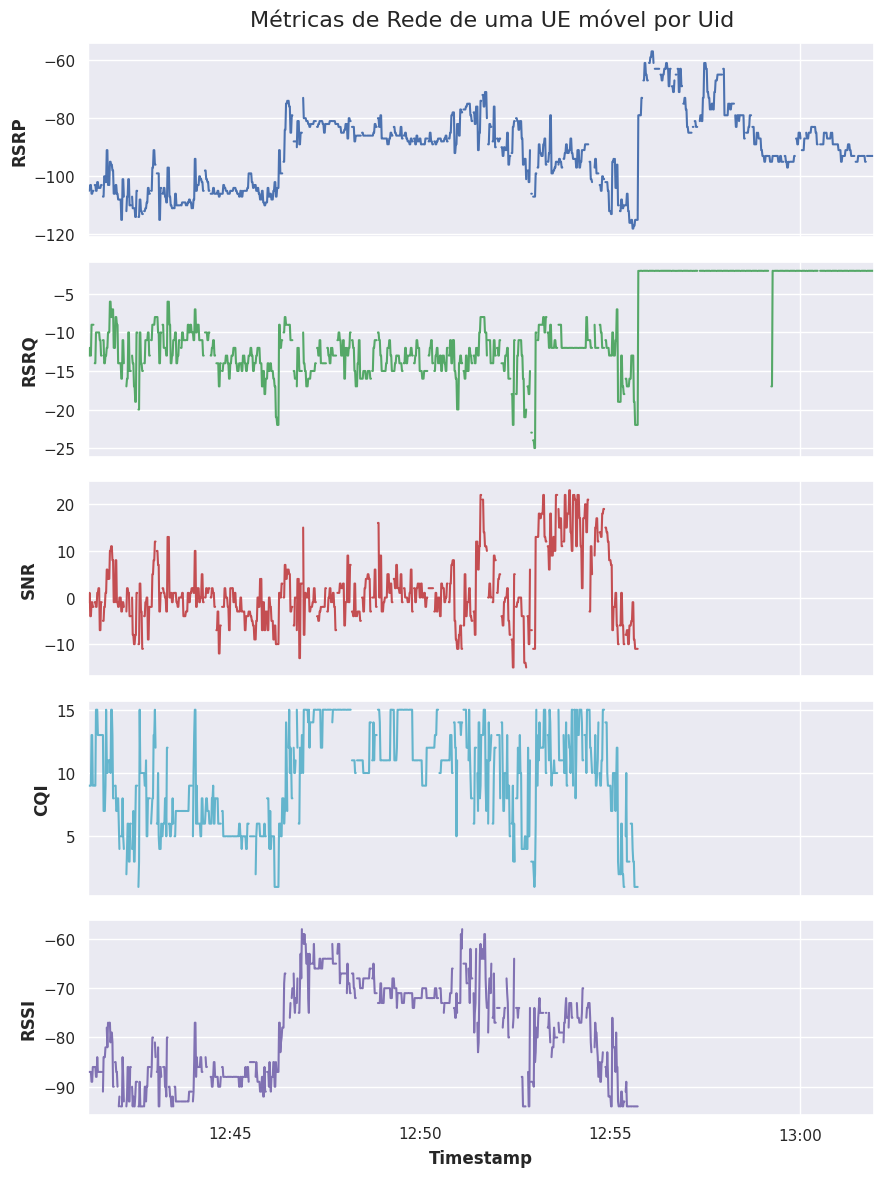

In [19]:
# Criar a figura e os eixos
fig, ax = plt.subplots(5, 1, figsize=(10, 12), sharex=True)

# Plotar as variáveis nos subplots
test_driving_df.plot(kind="line", y="RSRP", color="b", ax=ax[0], legend=False)
test_driving_df.plot(kind="line", y="RSRQ", color="g", ax=ax[1], legend=False)
test_driving_df.plot(kind="line", y="SNR", color="r", ax=ax[2], legend=False)
test_driving_df.plot(kind="line", y="CQI", color="c", ax=ax[3], legend=False)
test_driving_df.plot(kind="line", y="RSSI", color="m", ax=ax[4], legend=False)

# Definir os títulos de cada eixo y
ax[0].set_ylabel("RSRP")
ax[1].set_ylabel("RSRQ")
ax[2].set_ylabel("SNR")
ax[3].set_ylabel("CQI")
ax[4].set_ylabel("RSSI")

fig.suptitle("Métricas de Rede de uma UE móvel por Uid", fontsize=16)

# # Configurar a legenda em uma posição consistente
# lines = [ax[0].lines[0], ax[1].lines[0], ax[2].lines[0], ax[3].lines[0], ax[4].lines[0]]
# labels = ["RSRP", "RSRQ", "SNR", "CQI", "RSSI"]
# fig.legend(lines, labels, loc="upper right", bbox_to_anchor=(1.1, 1), title="Métricas")

# Ajustar o layout para evitar sobreposição
plt.tight_layout(rect=[0, 0, 0.9, 1])

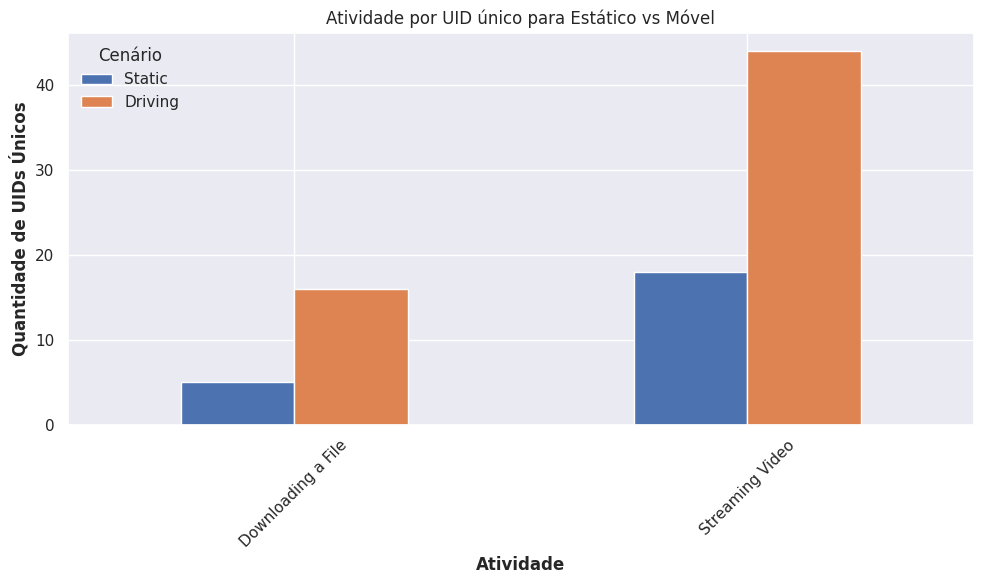

In [20]:
static_uid_counts = df_static.groupby("User_Activity")['Uid'].nunique().rename("Static")
driving_uid_counts = df_driving.groupby("User_Activity")['Uid'].nunique().rename("Driving")

# Combinar os resultados em um único DataFrame
combined_uid_counts = pd.concat([static_uid_counts, driving_uid_counts], axis=1)

# Plotar o gráfico de barras
combined_uid_counts.plot(kind="bar", figsize=(10, 6))
plt.title("Atividade por UID único para Estático vs Móvel")
plt.xlabel("Atividade")
plt.ylabel("Quantidade de UIDs Únicos")
plt.xticks(rotation=45)
plt.legend(title="Cenário")
plt.tight_layout()
plt.show()

## Verificação de Estacionaridade

### 1. Verificar a estacionaridade usando o Teste de Dickey-Fuller Aumentado

Uma série temporal é considerada "estacionária" se **não apresenta tendência**, exibe **variância constante** ao longo do tempo e possui uma estrutura de **autocorrelação constante** ao longo do tempo.

Uma maneira de testar se uma série temporal é estacionária é realizar um teste de **Dickey-Fuller aumentado**, que utiliza as seguintes hipóteses nulas e alternativas:

> $H_0$: A série temporal **não é estacionária**. Em outras palavras, ela possui alguma estrutura dependente do tempo e não apresenta variância constante ao longo do tempo.

> $H_A$: A série temporal **é estacionária**.

Se o **valor de p** do teste for **menor que** algum nível de **significância** (por exemplo, **α = 0,05**), então podemos **rejeitar a hipótese nula** e concluir que a série temporal **é estacionária**.

In [21]:
from statsmodels.tsa.stattools import adfuller

In [22]:
test_driving_df = (
    df_driving[df_driving.Uid == driving_uids[10]][["RSRP", "RSRQ", "SNR", "CQI", "RSSI"]]
    .asfreq(freq="S")
    .bfill()
)

<Axes: xlabel='Timestamp'>

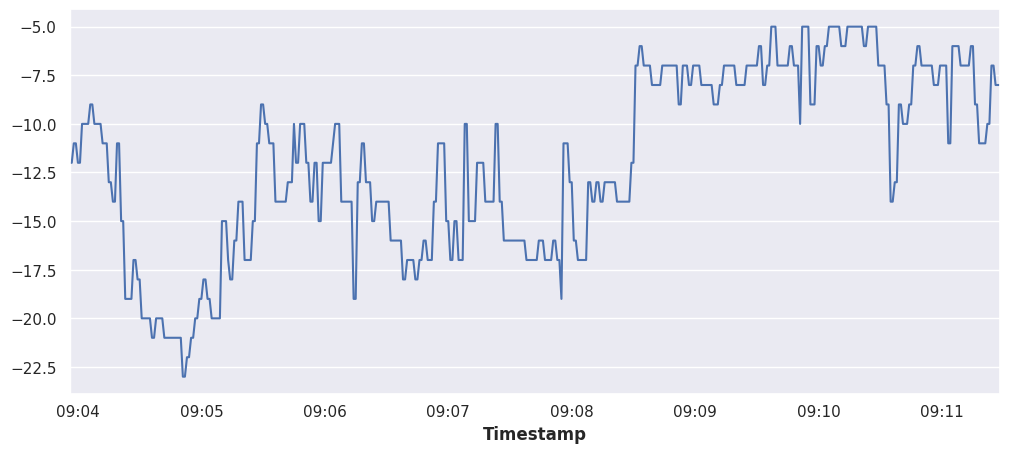

In [23]:
test_driving_df["RSRQ"].plot()

In [24]:
# Teste de Dickey-Fuller Aumentado
result = adfuller(test_driving_df["RSRQ"])
print("ADF Statistic:", result[0])
print("p-value:", result[1])

if result[1] < 0.05:
    print("A série é estacionária")
else:
    print("A série não é estacionária")

ADF Statistic: -2.0218496188657613
p-value: 0.27707573129452506
A série não é estacionária


Interpretação dos Resultados:

- **Estatística ADF (ADF Statistic):** Valor da estatística de teste. Valores mais negativos indicam uma série mais fortemente estacionária.
- **p-value:** Probabilidade associada ao teste. Um p-valor abaixo de 0.05 geralmente indica que a série é estacionária, pois rejeita a hipótese nula de que a série possui uma unidade raiz (não estacionária).
- **Valores Críticos (Critical Values):** Ponto de corte para diferentes níveis de significância (1%, 5%, e 10%).

## 2. Aplicação de Diferenciação para Remover Tendência. 

Se o p-valor do teste ADF for maior que 0.05, a série não é estacionária, e precisamos aplicar diferenciação.

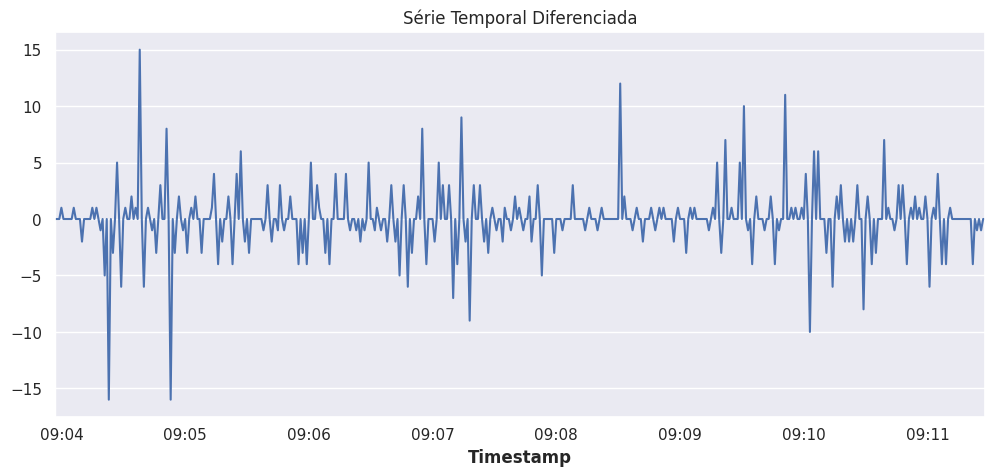

In [25]:
# Aplicando a primeira diferença
series_diff = test_driving_df["RSRP"].diff().dropna()

# Visualizar a série diferenciada
series_diff.plot(title="Série Temporal Diferenciada")
plt.show()

In [26]:
# Teste de Dickey-Fuller na série diferenciada
result_diff = adfuller(series_diff)
print("ADF Statistic (differenced):", result_diff[0])
print("p-value (differenced):", result_diff[1])

ADF Statistic (differenced): -12.987150093987132
p-value (differenced): 2.8624820901802593e-24


A diferenciação pode ser aplicada repetidamente a uma série temporal até que ela se torne estacionária. No contexto de modelagem ARIMA, o número de vezes que a diferenciação é aplicada está relacionado com o parâmetro d do modelo ARIMA (p, d, q).

- **Evite Overdifferencing:** Diferenciar a série mais do que o necessário pode levar a problemas na modelagem e na interpretação dos resultados. Idealmente, o número de diferenciações deve ser o menor possível para alcançar a estacionaridade.
- **Análise Visual:** Além dos testes estatísticos, análises visuais dos gráficos de séries temporais diferenciadas, ACF, e PACF também são úteis para decidir o nível adequado de diferenciação.

### 3. Autocorrelação (ACF) e a autocorrelação parcial (PACF) para identificar componentes sazonais

In [27]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


- Autocorrelação (ACF): 
  - O gráfico de autocorrelação mostra a correlação da série com suas próprias versões defasadas (lags). Quando uma série temporal possui componentes sazonais, o gráfico de ACF geralmente mostra picos em lags múltiplos do período sazonal. Por exemplo, se há um padrão sazonal anual em dados mensais, picos significativos na ACF aparecerão nos lags 12, 24, 36, etc.
- Autocorrelação parcial (PACF): 
  - O gráfico de autocorrelação parcial mostra a correlação entre a série e suas defasagens, excluindo o efeito das defasagens intermediárias. Na presença de sazonalidade, a PACF pode mostrar picos significativos nos lags correspondentes ao período sazonal. A PACF é útil para entender a estrutura subjacente de um modelo autorregressivo e para diferenciar entre componentes sazonais e de tendência.

In [28]:
test_driving_df = (
    df_driving[df_driving.Uid == driving_uids[10]][["RSRP", "RSRQ", "SNR", "CQI", "RSSI"]]
    .asfreq(freq="S")
    .bfill()
)

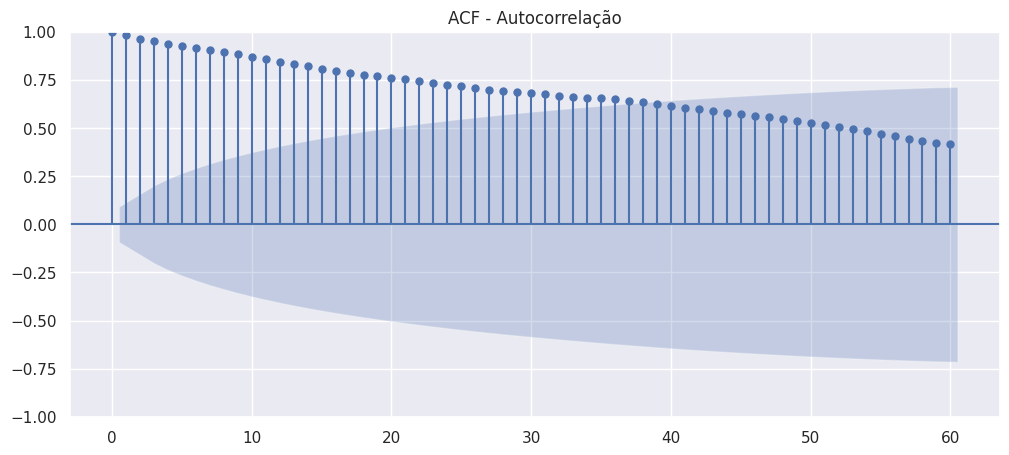

In [29]:
# Plotar ACF
plot_acf(test_driving_df["RSRP"], lags=60)
plt.title("ACF - Autocorrelação")
plt.show()

Interpretação do ACF:
- Apresentar um comportamento decrescente sem picos significativos em lags específicos, isso geralmente indica que a série temporal não possui uma sazonalidade forte ou distinta.

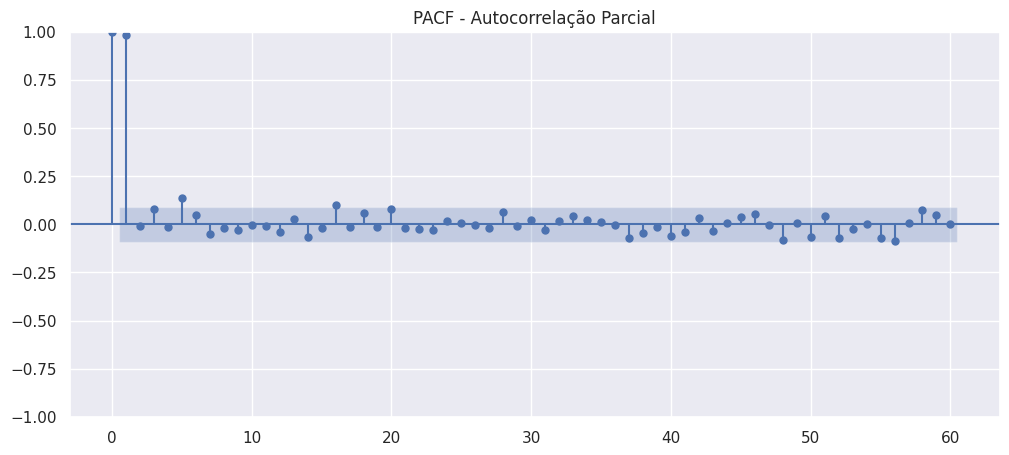

In [30]:
# Plotar PACF
plot_pacf(test_driving_df["RSRP"], lags=60)
plt.title("PACF - Autocorrelação Parcial")
plt.show()

Interpretação do PACF:
- Valor Alto em Lag 0:
    -Lag 0 representa a autocorrelação da série com ela mesma, que é sempre 1, pois cada ponto está perfeitamente correlacionado consigo mesmo.
- Valores Altos nos Lags 1 e 2:
    -Valores altos em lag 1 e especialmente em lag 2 sugerem que a série tem uma dependência significativa dos valores observados dois períodos antes. Isso é típico de um processo autoregressivo de ordem 2 (AR(2)).

Interpretação dos Gráficos
- ACF: Um ACF que decresce exponencialmente pode sugerir que a série é bem representada por um modelo autoregressivo (AR), onde os valores são influenciados pelos valores anteriores, mas essa influência decai com o tempo. Neste caso, a PACF pode mostrar um corte abrupto após o primeiro ou segundo lag, o que ajuda a identificar a ordem do modelo AR.
- PACF com Corte Abaixo de um Certo Lag: Um corte claro na PACF após o primeiro ou segundo lag sugere um modelo AR de baixa ordem.

## The Hodrick-Prescott Filter:

Separetes a time-series $y_t$ into a trend component $\tau_t$ and a cyclical component $c_t$.

$$ y_t = \tau_t + c_t $$

In [31]:
from statsmodels.tsa.filters.hp_filter import hpfilter

In [32]:
test_driving_df = (
    df_driving[df_driving.Uid == driving_uids[10]][["RSRP", "RSRQ", "SNR", "CQI", "RSSI"]]
    .asfreq(freq="S")
    .bfill()
)

In [33]:
RSRP_cycle, RSRP_trend = hpfilter(test_driving_df["RSRP"], lamb=1600)

<Axes: xlabel='Timestamp'>

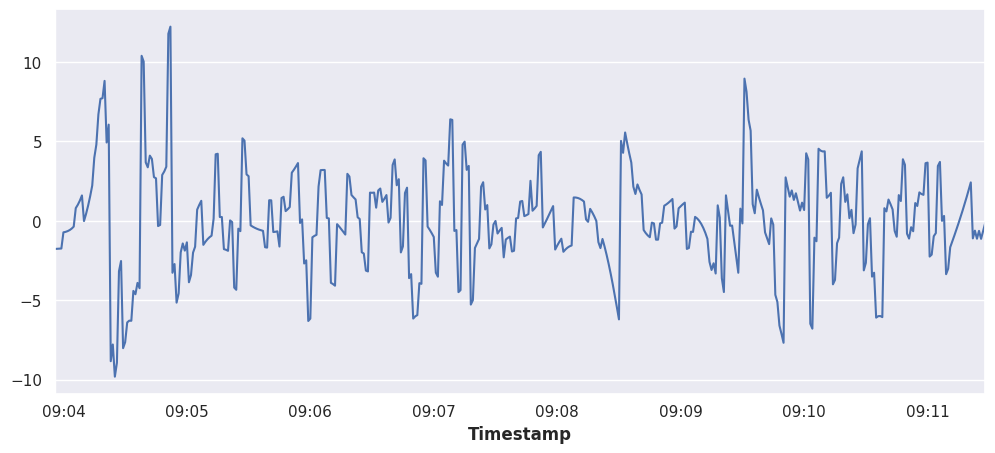

In [34]:
RSRP_cycle.plot()

<Axes: xlabel='Timestamp'>

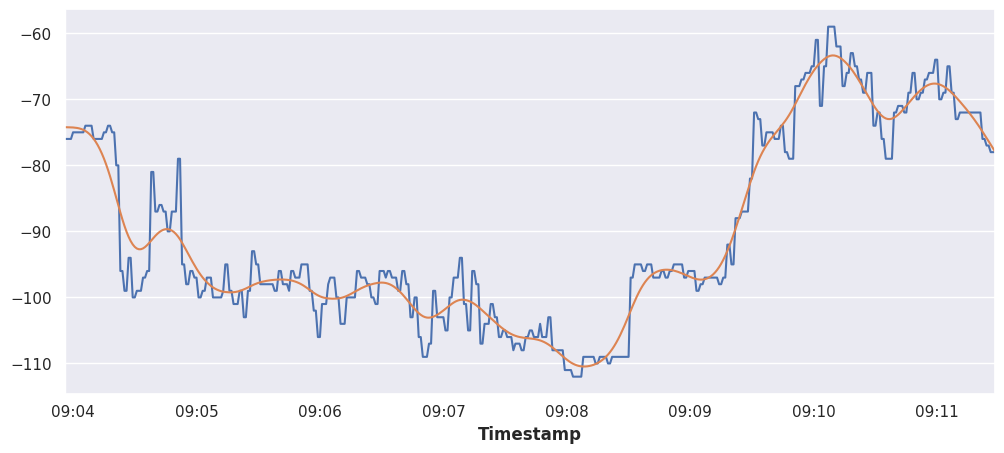

In [35]:
test_driving_df["RSRP"].plot()
RSRP_trend.plot()

## The ETS (Error-Trend-Seasonality) Models:

ETS (Exponential Smoothing) is a time series forecasting technique that combines three main components: error (E), trend (T), and seasonality (S). It smooths past data to predict future values by applying exponentially decreasing weights over time. There are various types of ETS models, including additive and multiplicative models, depending on how trend and seasonality interact with the time series data. ETS is particularly useful for data exhibiting seasonal patterns and trends, enabling accurate forecasts in scenarios where these components are significant.

- An additive model is applied when the trend appears linear and both the seasonality and trend components seem constant over time.
- A multiplicative model is more appropriate when the trend is increasing (or decreasing) at a non-linear rate.

In [36]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [37]:
test_driving_df = (
    df_driving[df_driving.Uid == driving_uids[10]][["RSRP", "RSRQ", "SNR", "CQI", "RSSI"]]
    .asfreq(freq="S")
    .bfill()
)

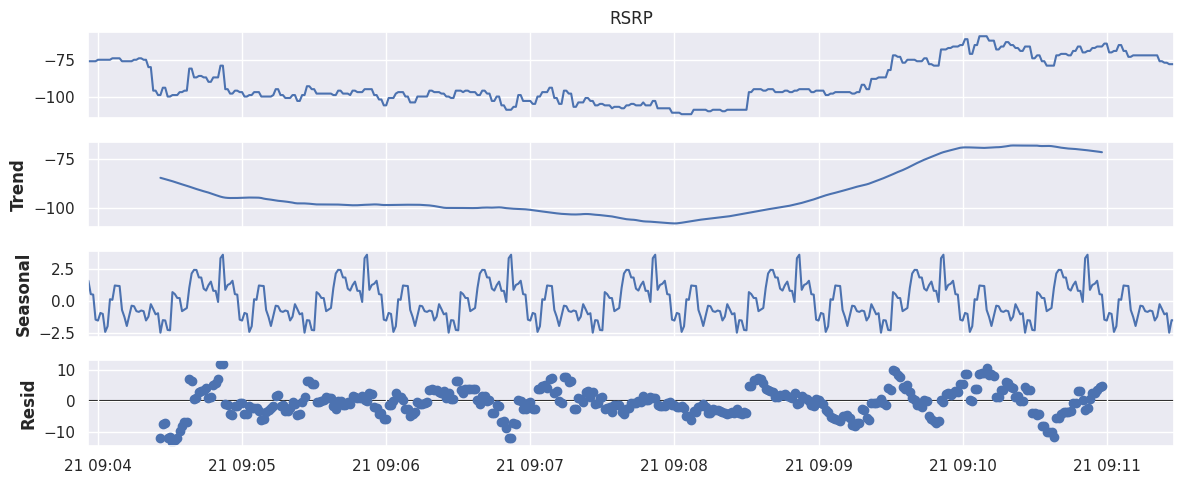

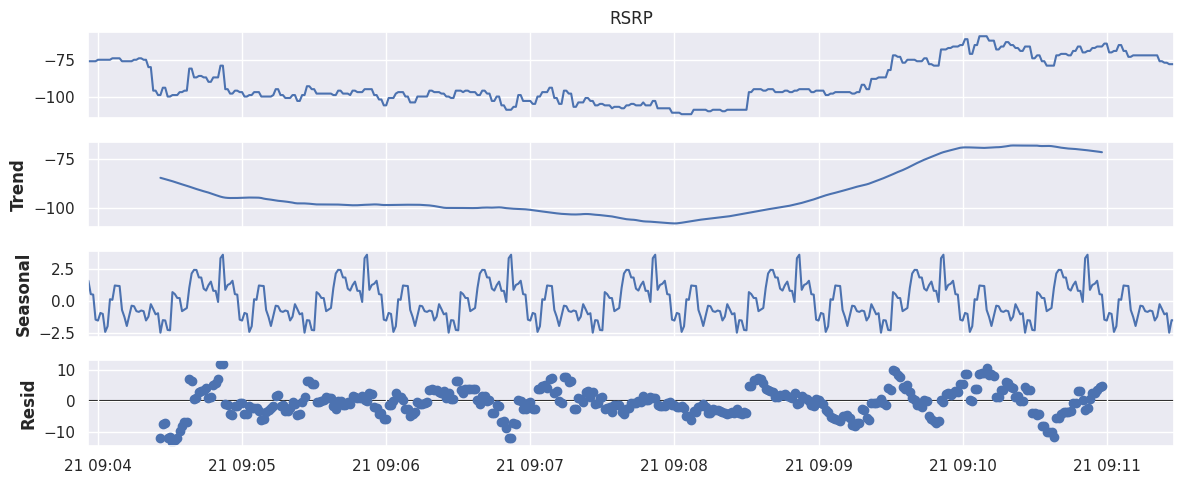

In [38]:
seasonal_decompose(test_driving_df["RSRP"], model="add", period=60).plot()

## Rolling Moving Average

In [39]:
test_driving_df = (
    df_driving[df_driving.Uid == driving_uids[10]][["RSRP", "RSRQ", "SNR", "CQI", "RSSI"]]
    .asfreq(freq="S")
    .bfill()
)

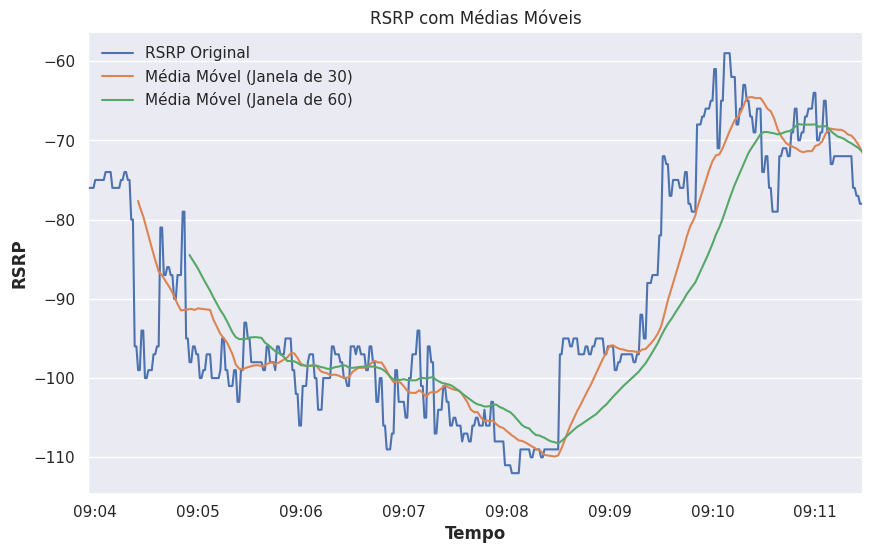

In [40]:
# Plot da série original de RSRP
test_driving_df["RSRP"].plot(label="RSRP Original", figsize=(10, 6))

# Plot da média móvel com janela de 30
test_driving_df["RSRP"].rolling(window=30).mean().plot(label="Média Móvel (Janela de 30)")

# Plot da média móvel com janela de 60
test_driving_df["RSRP"].rolling(window=60).mean().plot(label="Média Móvel (Janela de 60)")

# Adicionar título e legenda
plt.title("RSRP com Médias Móveis")
plt.xlabel("Tempo")
plt.ylabel("RSRP")
plt.legend()

## EWMA (Exponentially weighted moving average)

In [41]:
test_driving_df = (
    df_driving[df_driving.Uid == driving_uids[10]][["RSRP", "RSRQ", "SNR", "CQI", "RSSI"]]
    .asfreq(freq="S")
    .bfill()
)

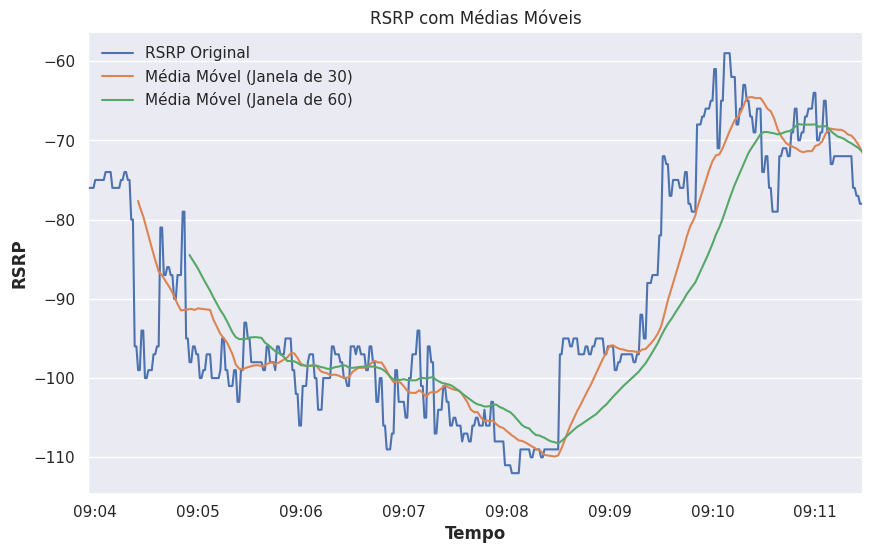

In [42]:
# Plot da série original de RSRP
test_driving_df["RSRP"].plot(label="RSRP Original", figsize=(10, 6))

# Plot da média móvel com janela de 30
test_driving_df["RSRP"].rolling(window=30).mean().plot(label="Média Móvel (Janela de 30)")

# Plot da média móvel com janela de 60
test_driving_df["RSRP"].rolling(window=60).mean().plot(label="Média Móvel (Janela de 60)")

# Adicionar título e legenda
plt.title("RSRP com Médias Móveis")
plt.xlabel("Tempo")
plt.ylabel("RSRP")
plt.legend()

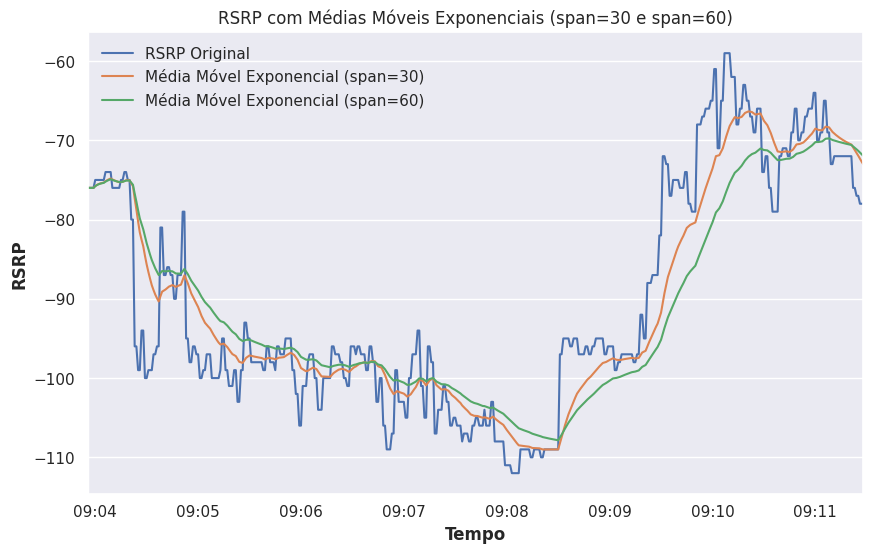

In [43]:
# Plot da série original de RSRP
test_driving_df["RSRP"].plot(label="RSRP Original", figsize=(10, 6))

# Plot da média móvel exponencial com span de 30
test_driving_df["RSRP"].ewm(span=30).mean().plot(label="Média Móvel Exponencial (span=30)")

# Plot da média móvel exponencial com span de 60
test_driving_df["RSRP"].ewm(span=60).mean().plot(label="Média Móvel Exponencial (span=60)")

# Adicionar título, legendas e exibir o gráfico
plt.title("RSRP com Médias Móveis Exponenciais (span=30 e span=60)")
plt.xlabel("Tempo")
plt.ylabel("RSRP")
plt.legend()

Estudar:

  - https://www.youtube.com/watch?v=CAT0Y66nPhs
  - https://github.com/unit8co/darts/blob/master/examples/01-multi-time-series-and-covariates.ipynb

Código para referência:

- https://github.com/KareemElozeiri/CQI-Timeseries-Forecasting/blob/main/notebooks/CQI_Time_Series_Forecasting.ipynb